# Introduction

According to the article "When college students post about depression on Facebook" by Jeff Grabmeier (https://news.osu.edu/when-college-students-post-about-depression-on-facebook/),

**"When college students post about feelings of depression on Facebook, their friends are unlikely to encourage them to seek help, a small study suggests. In fact, in this study, none of the 33 participating students said their friends told them they should reach out to a mental health professional to discuss their problems. Instead, most friends simply sent supportive or motivating messages. But that may not be good enough for people who are truly depressed – as some of the people in this study probably were, said Scottye Cash, lead author of the study and professor of social work at The Ohio State University.**

**“It makes me concerned that none of the Facebook friends of students in this study were proactive in helping their friend get help,” Cash said."**

reference: "When college students post about depression on Facebook" by Jeff Grabmeier (https://news.osu.edu/when-college-students-post-about-depression-on-facebook/)

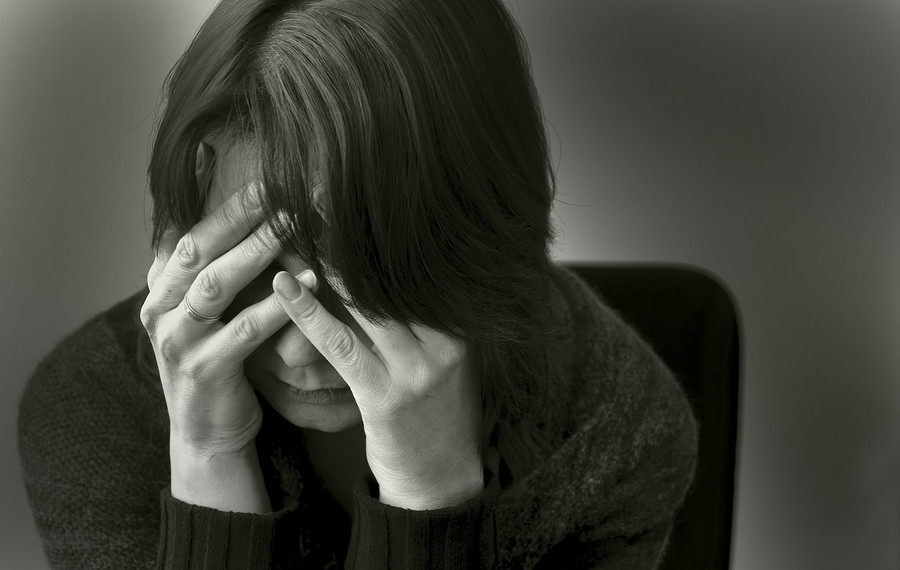

Image from https://www.health.harvard.edu/mind-and-mood/six-common-depression-types

It may means that one of the important things is that how we can find depressed post by students and how we can support them because sometimes it is difficult for them to be helpd by their friend only via SNS...

In this notebook, I tried to model students anxiety and depression classify model. For modeling, I also refered "Spam Classifier | NLP | 98% Accuracy
" by ANUBHAV GOYAL (https://www.kaggle.com/code/anubhavgoyal10/spam-classifier-nlp-98-accuracy). Thank you for sharing!

# Importing

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scikitplot.metrics import plot_confusion_matrix, plot_roc

# Data Outline

In [2]:

data = pd.read_excel('../input/students-anxiety-and-depression-dataset/dataset.xlsx')
data.head()

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0


In [3]:

print(data.shape)

(6982, 2)


In [4]:

data.isnull().sum()

text     10
label     2
dtype: int64

In [5]:

data=data.dropna(how='any')

In [6]:

data['label'].value_counts()

0.0    6240
1.0     730
Name: label, dtype: int64

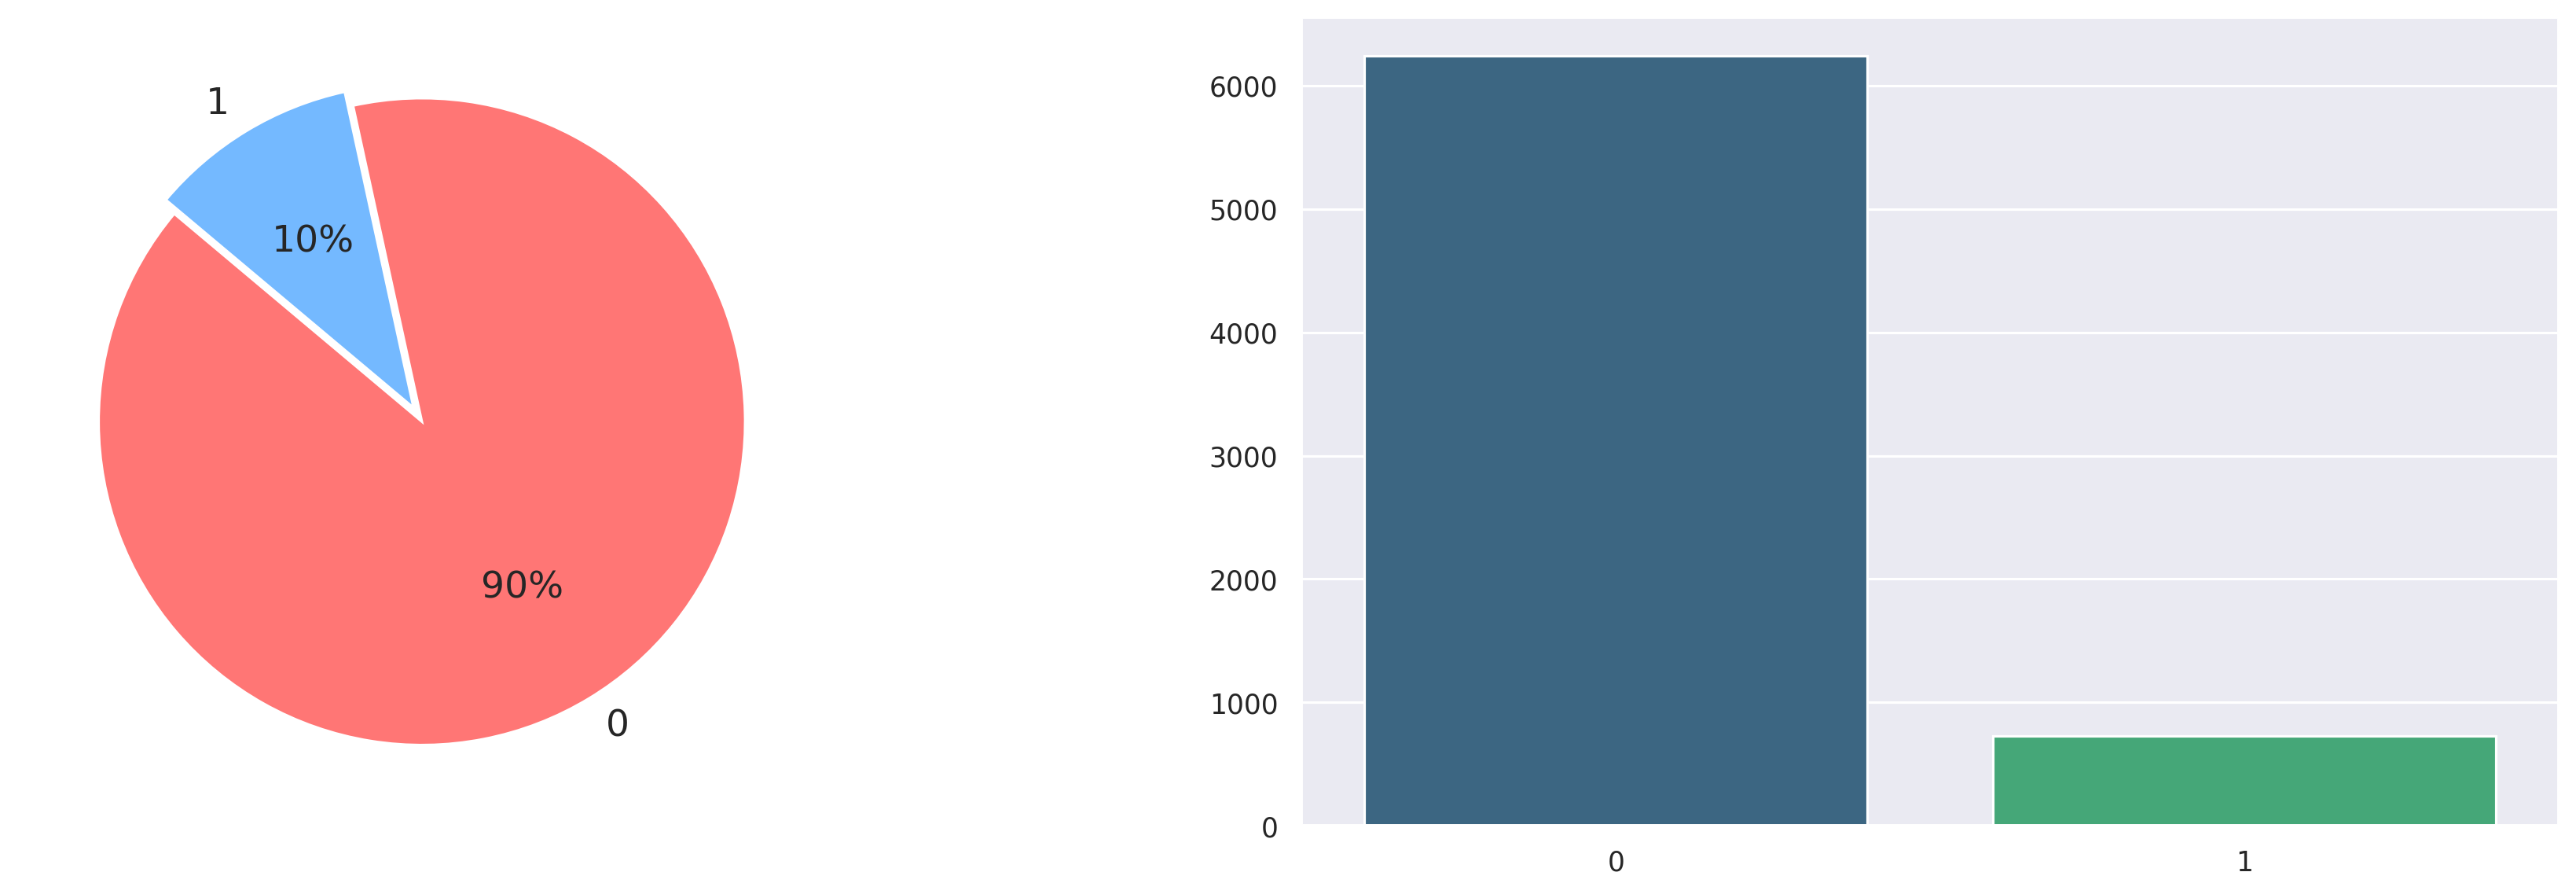

In [7]:

labels = [0,1]
sizes = [6240, 730]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 2)
sns.barplot(x=labels,y = sizes, palette= 'viridis')

plt.show()

# Features Engineering

In [8]:

data['Total Words'] = data['text'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["text"].apply(count_total_words)

In [9]:

data.head()

,text,label,Total Words,Total Chars
0,oh my gosh,1.0,3,8
1,"trouble sleeping, confused mind, restless hear...",1.0,10,55
2,"All wrong, back off dear, forward doubt. Stay ...",1.0,14,65
3,I've shifted my focus to something else but I'...,1.0,11,51
4,"I'm restless and restless, it's been a month n...",1.0,14,59


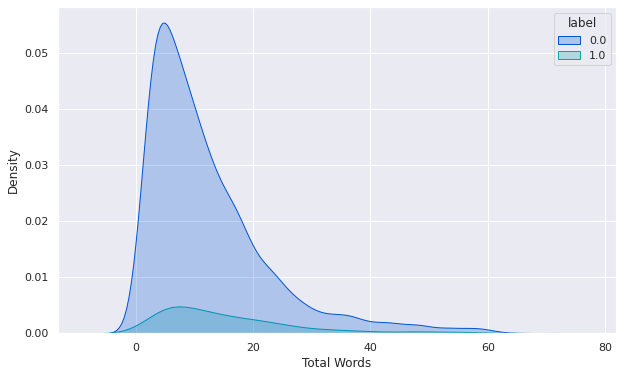

In [10]:

plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

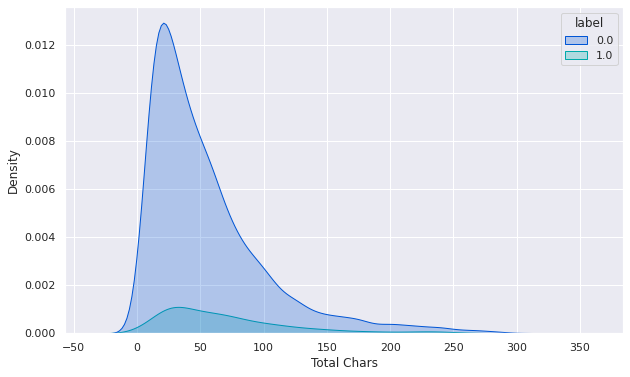

In [11]:

plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

# Text Preprocessing

In [12]:

data.head()

,text,label,Total Words,Total Chars
0,oh my gosh,1.0,3,8
1,"trouble sleeping, confused mind, restless hear...",1.0,10,55
2,"All wrong, back off dear, forward doubt. Stay ...",1.0,14,65
3,I've shifted my focus to something else but I'...,1.0,11,51
4,"I'm restless and restless, it's been a month n...",1.0,14,59


In [13]:

def convert_lowercase(text):
    text = text.lower()
    return text

data['text'] = data['text'].apply(convert_lowercase)

In [14]:

def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['text'] = data['text'].apply(remove_url)

In [15]:

exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['text'] = data['text'].apply(remove_punc)

In [16]:

def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['text'] = data['text'].apply(remove_stopwords)

In [17]:

def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['text'] = data['text'].apply(perform_stemming)

In [18]:

data['Total Words After Transformation'] = data['text'].apply(lambda x: np.log(len(x.split())))

In [19]:

data.head()

,text,label,Total Words,Total Chars,Total Words After Transformation
0,oh gosh,1.0,3,8,0.693147
1,troubl sleep confus mind restless heart tune,1.0,10,55,1.945910
2,wrong back dear forward doubt stay restless re...,1.0,14,65,2.197225
3,ive shift focu someth els im still worri,1.0,11,51,2.079442
4,im restless restless month boy mean,1.0,14,59,1.791759


# Visualization

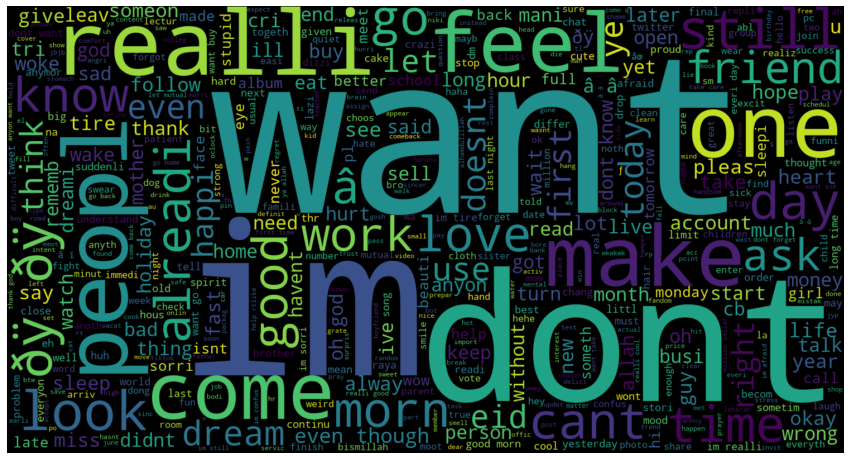

In [20]:

text = " ".join(data[data['label'] == 0]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

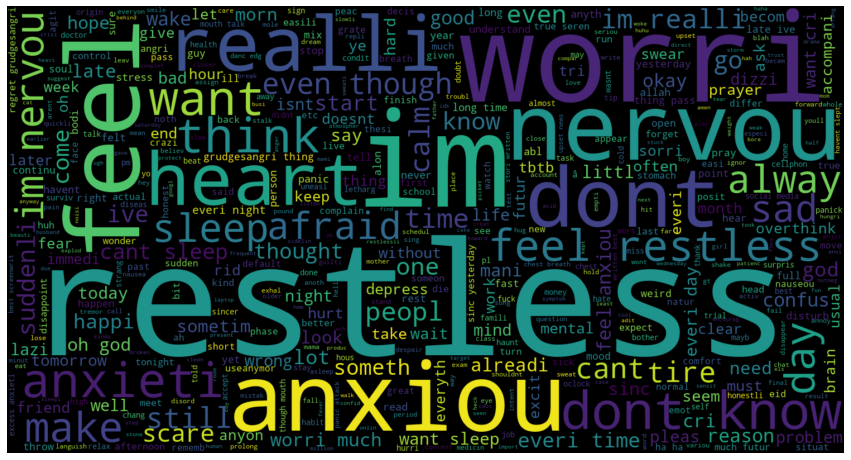

In [21]:

text = " ".join(data[data['label'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

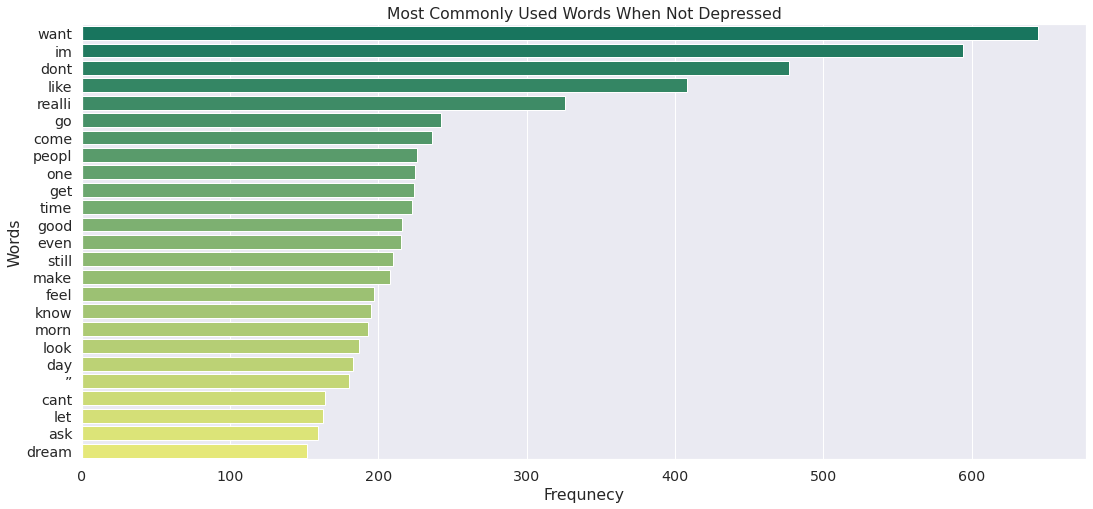

In [22]:

all_nodep_words = []
for sentence in data[data['label'] == 0]['text'].to_list():
    for word in sentence.split():
        all_nodep_words.append(word)

df = pd.DataFrame(Counter(all_nodep_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words When Not Depressed")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

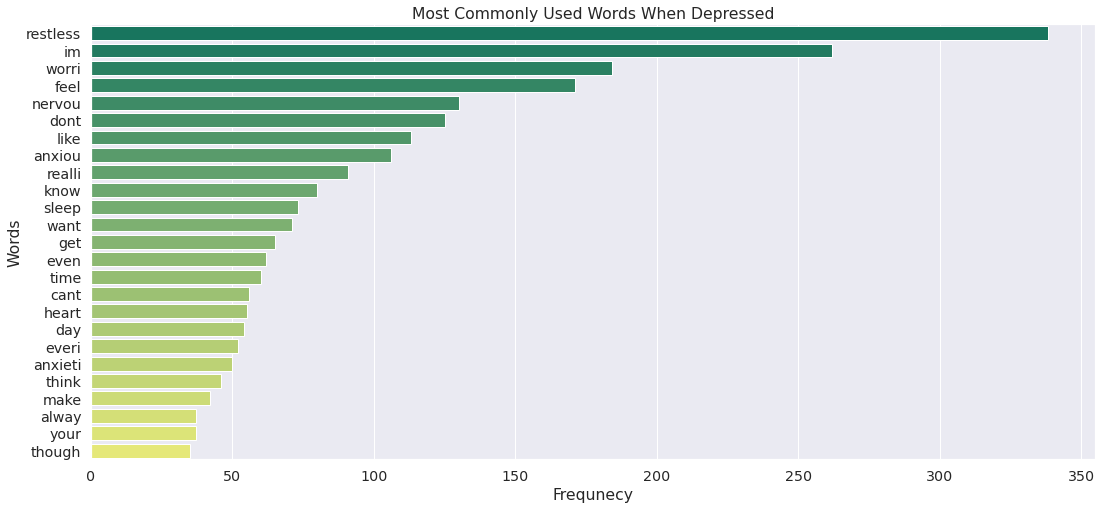

In [23]:

all_dep_words = []
for sentence in data[data['label'] == 1]['text'].to_list():
    for word in sentence.split():
        all_dep_words.append(word)

df = pd.DataFrame(Counter(all_dep_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words When Depressed")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

# Vectorization

In [24]:

X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [25]:

tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

# Modeling

# 1) Naive Bayes

In [26]:

def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

Accuracy of the model: 0.934
Precision Score of the model: 1.0
Recall Score of the model: 0.37


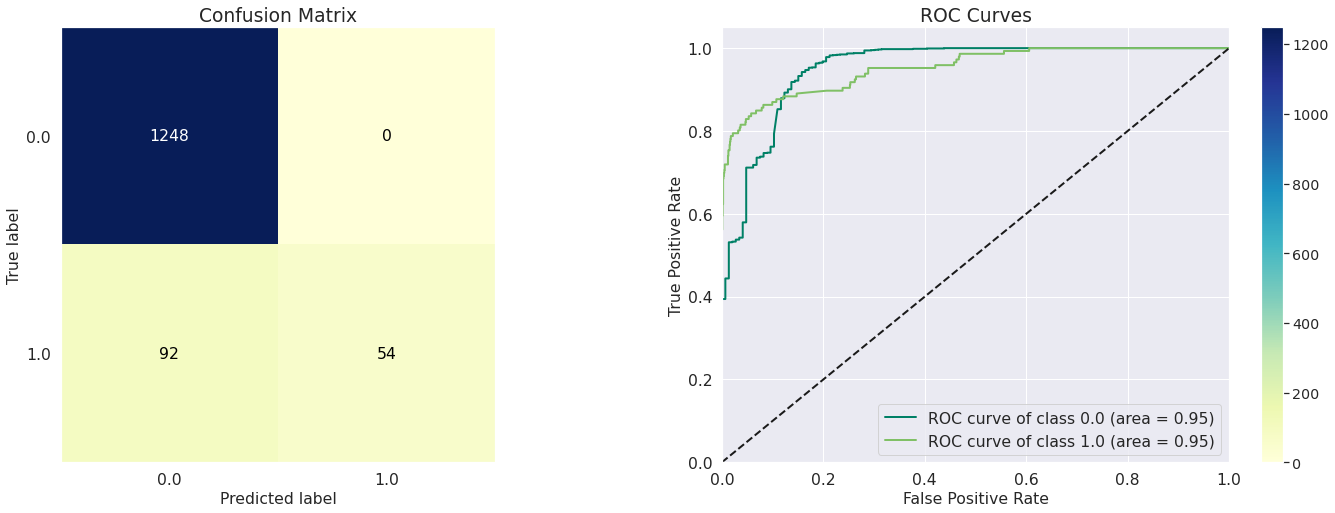

In [27]:

nb = MultinomialNB()
train_model(nb)

# 2) Random Forest

Accuracy of the model: 0.989
Precision Score of the model: 0.978
Recall Score of the model: 0.918


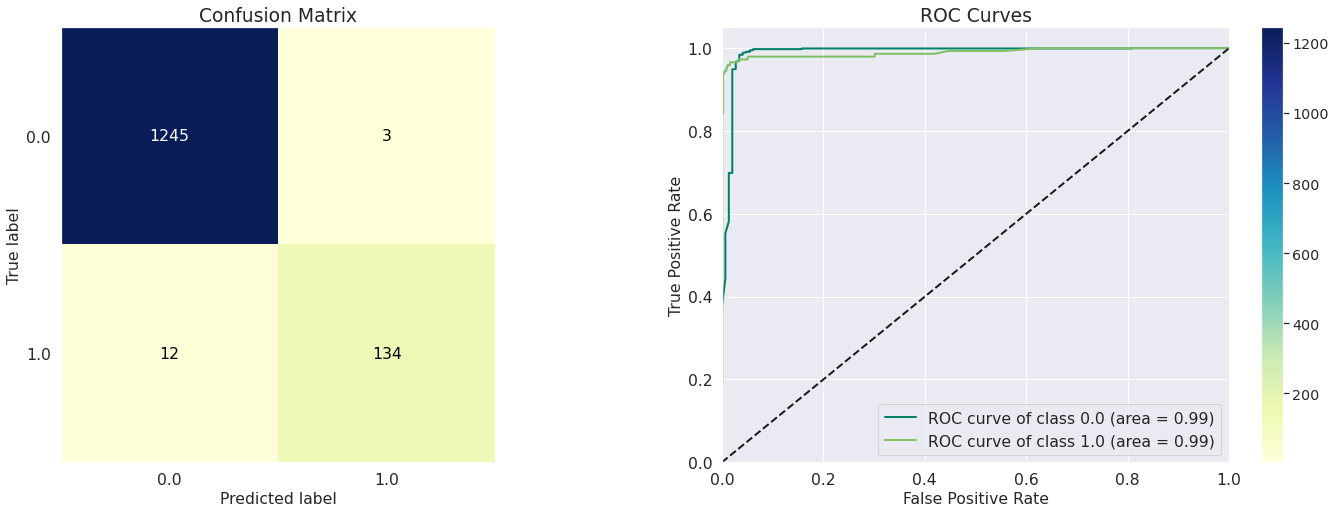

In [28]:

rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)

**Random Forest seems to be better!**